In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from collections import defaultdict
from yellowbrick.contrib.classifier import DecisionViz
from sklearn.decomposition import PCA
from itertools import product
from imblearn.datasets import make_imbalance
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from yellowbrick.datasets import load_credit
from yellowbrick.features import PCA as yPCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score 
from scikitplot.metrics import plot_precision_recall, plot_roc, plot_cumulative_gain, plot_lift_curve
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import KFold
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, classification_report

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV


c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.
c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\matte\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a futur

In [3]:
# Dataset con attributi originali
df = pd.read_csv("dataset_All_normalized.csv")
class_name = 'Occupancy'

In [4]:
df.head()

,Temperature,Light,CO2,HumidityRatio,Day,Afternoon,Evening,Night,Weekday,Weekend,Occupancy
0,0.869029,0.603964,0.208231,0.549737,0,1,0,0,1,0,1
1,0.872357,0.596946,0.215163,0.551972,0,1,0,0,1,0,1
2,0.874576,0.591029,0.220898,0.549997,0,1,0,0,1,0,1
3,0.873190,0.509582,0.224045,0.544374,0,1,0,0,1,0,1
4,0.879014,0.504267,0.226675,0.550376,0,1,0,0,1,0,1


In [4]:
attributes = [col for col in df.columns if col != class_name]
X = df[attributes].values
y = df[class_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1000, stratify=y)

In [5]:
def result_pred(y_true, y_pred):
    print("**** Matrice di Confusione *****")
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(' True negative: %d False negative: %d' % (tn, fn))
    print(' True positive: %d False positive: %d' % (tp, fp))
    print("____________________________________________")

    # Calcolo dell'accuracy
    print("***** Calcolo dell'accuracy *****")
    accuracy = accuracy_score(y_true, y_pred)    
    print('Frazione di campioni correttamente correlati: %0.4f' % accuracy)
    accuracy = accuracy_score(y_true, y_pred, False)
    print("Numero di campioni correttamente correlati: ", accuracy)    
    print("____________________________________________")

    # Calcolo della precision
    print("**** Calcolo della precisione *****")
    #Percentuale di classificazioni positive che sono corrette
    #se dico "positivo" dico giusto?
    precision = precision_score(y_true, y_pred)
    print('Percentuale di classificazioni positive che sono corrette: %0.4f' % precision)   
    print("____________________________________________")    

    # Calcolo della recall
    print("**** Calcolo della recall (sensitivity) *****")
    recall = recall_score(y_true, y_pred)
    print('Percentuale di elementi positivi del testing set che sono stati classificati come positivi: %0.4f' % recall)
    print("____________________________________________")    

    # Calcolo della specificity
    print("**** Calcolo della specificity *****")
    specificity = tn / (tn+fp)
    print('Percentuale di elementi negativi del testing set che sono stati classificati come negativi: %0.4f' % specificity)
    print("____________________________________________")   
    
    # Calcolo dell'F1 score
    print("**** Calcolo della F1 score *****")
    f1 = f1_score(y_true, y_pred)
    #Il punteggio F1 può essere interpretato come una media ponderata della precisione e della recall, 
    #in cui un punteggio F1 raggiunge il suo valore migliore a 1 e il punteggio peggiore a 0.
    print('F1 scores: %0.4f' % f1)
    print("____________________________________________")   
    
    # Stampiamo le stesse statistiche dalla funzione report
    print(classification_report(y_test, y_pred))
    
    print("Con le tecniche viste finora non viene fornita nessuna informazione sulla “gravità” degli errori (“errore lieve” oppure “errore grave)")
    print("per questo si usano la curva CMC, la curva ROC")


In [6]:
def plot_res(y_pred, y_score, y_test):
    #ROC CURVE: implementazione legata esclusivamente all'attività di classificazione binaria
    #false positive rate, true positive rate
    print("****** ROC CURVE + AUC?: passo passo *******")
    fprate, tprate, threashold = roc_curve(y_test, y_score[:, 1])
    auc_score = auc(fprate, tprate)
    plt.plot(fprate, tprate, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (auc_score))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC curve', fontsize=16)
    plt.legend(loc="lower right", fontsize=14, frameon=False)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.show()

    print("____________________________________")
    print("****** VALORE DI AUC *******")    
    print(roc_auc_score(y_test, y_score[:,1]))    
    
    print("____________________________________")
    print("****** ROC CURVE: con metodo diretto *******")
    plot_roc(y_test, y_score)
    plt.show()
    
    print("____________________________________")
    print("****** Precision recall: con metodo diretto *******")
    plot_precision_recall(y_test, y_score)
    plt.show()
    

    print("____________________________________")
    print("****** Cumulative gain: con metodo diretto *******")
    plot_cumulative_gain(y_test, y_score)
    plt.show()
    
    
    print("____________________________________")
    print("****** Lift curve: con metodo diretto *******")    
    plot_lift_curve(y_test, y_score)
    plt.show()

In [7]:
def plt_single_perceptron(name_csv, pnl):
    df = pd.read_csv(name_csv)
    fig = plt.figure(figsize=(16,8))
    fig.canvas.manager.full_screen_toggle()

    fig.suptitle('Single Perceptron', fontsize=15, fontweight='bold')
    penalty = pnl
    df = df.loc[(df.penalty == penalty)][['f1','std_dev', 'alpha','tol']]
    pivot = df.pivot('alpha','tol', 'f1')
    labels = pivot.as_matrix().astype(str)

    x = 0
    for i in range(0, pivot.shape[0]):
        for j in range(0, pivot.shape[1]):
            labels[i,j] = str(labels[i,j])[:5] + "\n+/- " + "{0:.3f}".format(df['std_dev'].iloc[x])
            x += 1

    sns.heatmap(pivot, cmap="YlGnBu", annot=labels, fmt="", cbar=False, square=True, linewidths=.5, cbar_kws={"shrink": .5})

    plt.show()

# -------------------------- Neural Networks -----------------------------------

# 1) Single Perceptron

In [8]:
from sklearn.linear_model import Perceptron

### Grid Search

In [9]:


# READ AND DROP COLUMNS
y = df['Occupancy']
X = df.drop(columns=['Occupancy'])

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1000, stratify=y)
# Set the parameters by cross-validation

tuned_parameters = {
    'penalty': ['l2','l1','elasticnet'],
    'alpha': [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03],
    'tol': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
}

# Set the parameters by cross-validation
k_fold = StratifiedKFold(n_splits=4, random_state=42)


#scores = ['recall', 'f1', 'accuracy' , 'precision']
scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for ----> %s" % score)
    print()

    svm = Perceptron()

    #if (score == "recall"):
    clf = GridSearchCV(svm, tuned_parameters, scoring=score, error_score='raise', cv=k_fold)

    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
    print("**** Matrice di Confusione *****")
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(' True negative: %d False negative: %d' % (tn, fn))
    print(' True positive: %d False positive: %d' % (tp, fp))
    print("____________________________________________")
    
    f1_val = []
    for i in means:
        f1_val.append("%0.3f" % i)
    
    std_val = []
    for i in stds:
        std_val.append("%0.3f" % (i*2))
    
    par1 = []
    par2 = []
    par3 = []
    for i in clf.cv_results_['params']:
        par1.append(i["alpha"])
        par2.append(i["penalty"])
        par3.append(i["tol"])
    data = {'f1': f1_val, "std_dev":std_val, "alpha":par1, "penalty":par2, "tol": par3}

    res = pd.DataFrame (data, columns = ["f1", "std_dev", "alpha", "penalty", "tol"])
    res.to_csv('single_perceptron_results.csv', index=False)

C:\Users\Federica\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


# Tuning hyper-parameters for ----> f1

Best parameters set found on development set:

{'alpha': 0.0003, 'penalty': 'l1', 'tol': 0.001}

Grid scores on development set:

0.962 (+/-0.043) for {'alpha': 0.0001, 'penalty': 'l2', 'tol': 0.1}
0.962 (+/-0.043) for {'alpha': 0.0001, 'penalty': 'l2', 'tol': 0.01}
0.964 (+/-0.053) for {'alpha': 0.0001, 'penalty': 'l2', 'tol': 0.001}
0.903 (+/-0.261) for {'alpha': 0.0001, 'penalty': 'l2', 'tol': 0.0001}
0.903 (+/-0.261) for {'alpha': 0.0001, 'penalty': 'l2', 'tol': 1e-05}
0.978 (+/-0.002) for {'alpha': 0.0001, 'penalty': 'l2', 'tol': 1e-06}
0.978 (+/-0.005) for {'alpha': 0.0001, 'penalty': 'l1', 'tol': 0.1}
0.978 (+/-0.005) for {'alpha': 0.0001, 'penalty': 'l1', 'tol': 0.01}
0.969 (+/-0.015) for {'alpha': 0.0001, 'penalty': 'l1', 'tol': 0.001}
0.879 (+/-0.350) for {'alpha': 0.0001, 'penalty': 'l1', 'tol': 0.0001}
0.879 (+/-0.350) for {'alpha': 0.0001, 'penalty': 'l1', 'tol': 1e-05}
0.879 (+/-0.350) for {'alpha': 0.0001, 'penalty': 'l1', 'tol': 1

C:\Users\Federica\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


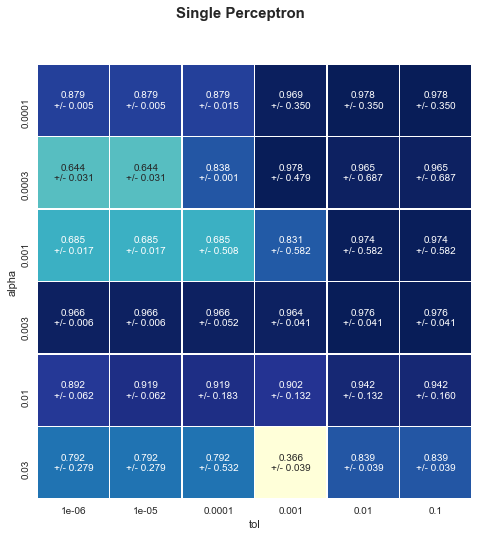

In [10]:
plt_single_perceptron("single_perceptron_results.csv", "l1")

**** Matrice di Confusione *****
 True negative: 4673 False negative: 0
 True positive: 1425 False positive: 70
____________________________________________
***** Calcolo dell'accuracy *****
Frazione di campioni correttamente correlati: 0.9887
Numero di campioni correttamente correlati:  6098
____________________________________________
**** Calcolo della precisione *****
Percentuale di classificazioni positive che sono corrette: 0.9532
____________________________________________
**** Calcolo della recall (sensitivity) *****
Percentuale di elementi positivi del testing set che sono stati classificati come positivi: 1.0000
____________________________________________
**** Calcolo della specificity *****
Percentuale di elementi negativi del testing set che sono stati classificati come negativi: 0.9852
____________________________________________
**** Calcolo della F1 score *****
F1 scores: 0.9760
____________________________________________
              precision    recall  f1-score   

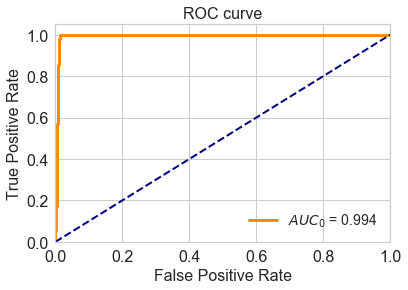

____________________________________
****** VALORE DI AUC *******
0.9940496613661499
____________________________________
****** ROC CURVE: con metodo diretto *******


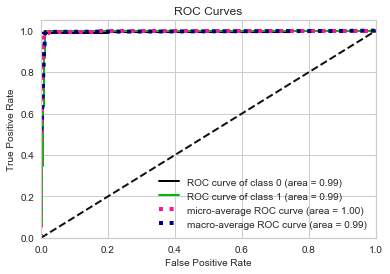

____________________________________
****** Precision recall: con metodo diretto *******


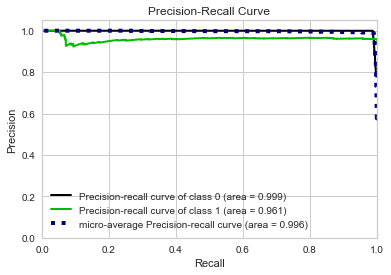

____________________________________
****** Cumulative gain: con metodo diretto *******


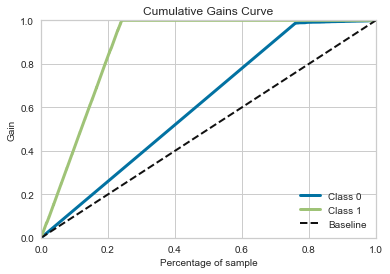

____________________________________
****** Lift curve: con metodo diretto *******


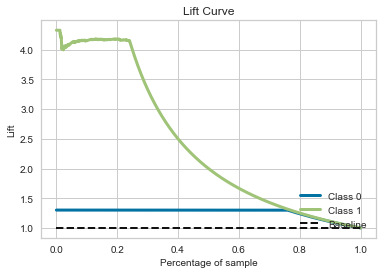

In [11]:
from sklearn.calibration import CalibratedClassifierCV
clf = Perceptron(alpha = 0.0003, penalty = "l1", tol=0.001)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
result_pred(y_test, y_pred)
#y_score = clf.predict_proba(X_test)
cclf = CalibratedClassifierCV(base_estimator=Perceptron(alpha = 0.0003, penalty = "l1", tol=0.001), cv=5)
cclf.fit(X_train, y_train)
y_pred = cclf.predict(X_test)
y_score = cclf.predict_proba(X_test)
result_pred(y_test, y_pred)
#plot_res_linearSVC(y_pred, y_score[:, 1], y_test)
plot_res(y_pred, y_score, y_test)

## Single Perceptron + Oversampling

In [12]:
# READ AND DROP COLUMNS
y = df['Occupancy']
X = df.drop(columns=['Occupancy'])
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=1000, stratify = y_res)

tuned_parameters = {
    'penalty': ['l2','l1','elasticnet'],
    'alpha': [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03],
    'tol': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
}

# Set the parameters by cross-validation
k_fold = StratifiedKFold(n_splits=4, random_state=42)


#scores = ['recall', 'f1', 'accuracy' , 'precision']
scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for ----> %s" % score)
    print()

    svm = Perceptron()

    clf = GridSearchCV(svm, tuned_parameters, scoring=score, error_score='raise', cv=k_fold)

    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
    print("**** Matrice di Confusione *****")
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(' True negative: %d False negative: %d' % (tn, fn))
    print(' True positive: %d False positive: %d' % (tp, fp))
    print("____________________________________________")

Resampled dataset shape Counter({1: 15810, 0: 15810})
# Tuning hyper-parameters for ----> f1



C:\Users\Federica\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Best parameters set found on development set:

{'alpha': 0.0001, 'penalty': 'l1', 'tol': 1e-05}

Grid scores on development set:

0.984 (+/-0.020) for {'alpha': 0.0001, 'penalty': 'l2', 'tol': 0.1}
0.984 (+/-0.020) for {'alpha': 0.0001, 'penalty': 'l2', 'tol': 0.01}
0.991 (+/-0.005) for {'alpha': 0.0001, 'penalty': 'l2', 'tol': 0.001}
0.991 (+/-0.005) for {'alpha': 0.0001, 'penalty': 'l2', 'tol': 0.0001}
0.991 (+/-0.005) for {'alpha': 0.0001, 'penalty': 'l2', 'tol': 1e-05}
0.991 (+/-0.005) for {'alpha': 0.0001, 'penalty': 'l2', 'tol': 1e-06}
0.991 (+/-0.003) for {'alpha': 0.0001, 'penalty': 'l1', 'tol': 0.1}
0.991 (+/-0.003) for {'alpha': 0.0001, 'penalty': 'l1', 'tol': 0.01}
0.871 (+/-0.420) for {'alpha': 0.0001, 'penalty': 'l1', 'tol': 0.001}
0.871 (+/-0.421) for {'alpha': 0.0001, 'penalty': 'l1', 'tol': 0.0001}
0.993 (+/-0.002) for {'alpha': 0.0001, 'penalty': 'l1', 'tol': 1e-05}
0.993 (+/-0.002) for {'alpha': 0.0001, 'penalty': 'l1', 'tol': 1e-06}
0.984 (+/-0.020) for {'alpha': 0.0

In [13]:
#'C': 0.001, 'gamma': 2, 'kernel': 'poly'
# READ AND DROP COLUMNS
y = df['Occupancy']
X = df.drop(columns=['Occupancy'])
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))
# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=1000, stratify = y_res)
clf = Perceptron(alpha = 0.0001, penalty = "l1", tol=1e-05)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
result_pred(y_test, y_pred)
#y_score = clf.predict_proba(X_test)

Resampled dataset shape Counter({1: 15810, 0: 15810})
**** Matrice di Confusione *****
 True negative: 4682 False negative: 9
 True positive: 4734 False positive: 61
____________________________________________
***** Calcolo dell'accuracy *****
Frazione di campioni correttamente correlati: 0.9926
Numero di campioni correttamente correlati:  9416
____________________________________________
**** Calcolo della precisione *****
Percentuale di classificazioni positive che sono corrette: 0.9873
____________________________________________
**** Calcolo della recall (sensitivity) *****
Percentuale di elementi positivi del testing set che sono stati classificati come positivi: 0.9981
____________________________________________
**** Calcolo della specificity *****
Percentuale di elementi negativi del testing set che sono stati classificati come negativi: 0.9871
____________________________________________
**** Calcolo della F1 score *****
F1 scores: 0.9927
_____________________________________

## Single Perceptron +Undersampling

In [14]:
# READ AND DROP COLUMNS
y = df['Occupancy']
X = df.drop(columns=['Occupancy'])
ros = RandomUnderSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=1000, stratify = y_res)

tuned_parameters = {
    'penalty': ['l2','l1','elasticnet'],
    'alpha': [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03],
    'tol': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
}

# Set the parameters by cross-validation
k_fold = StratifiedKFold(n_splits=4, random_state=42)


#scores = ['recall', 'f1', 'accuracy' , 'precision']
scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for ----> %s" % score)
    print()

    svm = Perceptron()

    clf = GridSearchCV(svm, tuned_parameters, scoring=score, error_score='raise', cv=k_fold)

    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
    print("**** Matrice di Confusione *****")
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(' True negative: %d False negative: %d' % (tn, fn))
    print(' True positive: %d False positive: %d' % (tp, fp))
    print("____________________________________________")

Resampled dataset shape Counter({0: 4750, 1: 4750})
# Tuning hyper-parameters for ----> f1



C:\Users\Federica\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Best parameters set found on development set:

{'alpha': 0.0001, 'penalty': 'l1', 'tol': 0.1}

Grid scores on development set:

0.989 (+/-0.006) for {'alpha': 0.0001, 'penalty': 'l2', 'tol': 0.1}
0.990 (+/-0.004) for {'alpha': 0.0001, 'penalty': 'l2', 'tol': 0.01}
0.987 (+/-0.006) for {'alpha': 0.0001, 'penalty': 'l2', 'tol': 0.001}
0.967 (+/-0.073) for {'alpha': 0.0001, 'penalty': 'l2', 'tol': 0.0001}
0.967 (+/-0.073) for {'alpha': 0.0001, 'penalty': 'l2', 'tol': 1e-05}
0.967 (+/-0.073) for {'alpha': 0.0001, 'penalty': 'l2', 'tol': 1e-06}
0.992 (+/-0.003) for {'alpha': 0.0001, 'penalty': 'l1', 'tol': 0.1}
0.992 (+/-0.004) for {'alpha': 0.0001, 'penalty': 'l1', 'tol': 0.01}
0.977 (+/-0.046) for {'alpha': 0.0001, 'penalty': 'l1', 'tol': 0.001}
0.978 (+/-0.047) for {'alpha': 0.0001, 'penalty': 'l1', 'tol': 0.0001}
0.977 (+/-0.047) for {'alpha': 0.0001, 'penalty': 'l1', 'tol': 1e-05}
0.977 (+/-0.047) for {'alpha': 0.0001, 'penalty': 'l1', 'tol': 1e-06}
0.989 (+/-0.006) for {'alpha': 0.000

In [15]:
y = df['Occupancy']
X = df.drop(columns=['Occupancy'])
ros = RandomUnderSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))
# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=1000, stratify = y_res)
clf = Perceptron(alpha = 0.0001, penalty = "l1", tol=0.1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
result_pred(y_test, y_pred)

Resampled dataset shape Counter({0: 4750, 1: 4750})
**** Matrice di Confusione *****
 True negative: 1418 False negative: 1
 True positive: 1424 False positive: 7
____________________________________________
***** Calcolo dell'accuracy *****
Frazione di campioni correttamente correlati: 0.9972
Numero di campioni correttamente correlati:  2842
____________________________________________
**** Calcolo della precisione *****
Percentuale di classificazioni positive che sono corrette: 0.9951
____________________________________________
**** Calcolo della recall (sensitivity) *****
Percentuale di elementi positivi del testing set che sono stati classificati come positivi: 0.9993
____________________________________________
**** Calcolo della specificity *****
Percentuale di elementi negativi del testing set che sono stati classificati come negativi: 0.9951
____________________________________________
**** Calcolo della F1 score *****
F1 scores: 0.9972
________________________________________

# 2) Multilayer Perceptron

In [7]:
from sklearn.neural_network import MLPClassifier
# READ AND DROP COLUMNS
y = df['Occupancy']
X = df.drop(columns=['Occupancy'])

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1000, stratify=y)

### Grid Search

In [11]:
import warnings
from sklearn.exceptions import ConvergenceWarning
# READ AND DROP COLUMNS
y = df['Occupancy']
X = df.drop(columns=['Occupancy'])

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1000, stratify=y)
# Set the parameters by cross-validation
k_fold = StratifiedKFold(n_splits=4, random_state=42)

tuned_parameters = {
    #'tol': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7],
    #'alpha': 10.0 ** -np.arange(1, 7), 
    'momentum' : [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9],
    'hidden_layer_sizes':[(12, 23, 11,), (23, 43, 32,), (128, 64, 32,)],
    'learning_rate': ['constant', 'invscaling', 'adaptive']
}

#scores = ['recall', 'f1', 'accuracy' , 'precision']
scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for ----> %s" % score)
    print()

    svm = MLPClassifier(solver = 'sgd')

    clf = GridSearchCV(svm, tuned_parameters, scoring=score, error_score='raise', cv=k_fold)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
        clf.fit(X_train, y_train)
    
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
    print("**** Matrice di Confusione *****")
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(' True negative: %d False negative: %d' % (tn, fn))
    print(' True positive: %d False positive: %d' % (tp, fp))
    print("____________________________________________")
    
    f1_val = []
    for i in means:
        f1_val.append("%0.3f" % i)
    
    std_val = []
    for i in stds:
        std_val.append("%0.3f" % (i*2))
    
    par1 = []
    par2 = []
    par3 = []
    for i in clf.cv_results_['params']:
        par1.append(i["hidden_layer_sizes"])
        par2.append(i["momentum"])
        par3.append(i["learning_rate"])
    data = {'f1': f1_val, "std_dev":std_val, "hidden_layer_sizes":par1, "momentum":par2, "learning_rate": par3}

    res = pd.DataFrame (data, columns = ["f1", "std_dev", "hidden_layer_sizes", "momentum", "learning_rate"])
    res.to_csv('multiple_perceptron_results.csv', index=False)

C:\Users\Federica\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


# Tuning hyper-parameters for ----> f1

Best parameters set found on development set:

{'hidden_layer_sizes': (12, 23, 11), 'learning_rate': 'adaptive', 'momentum': 0.9}

Grid scores on development set:

0.947 (+/-0.020) for {'hidden_layer_sizes': (12, 23, 11), 'learning_rate': 'constant', 'momentum': 0}
0.955 (+/-0.012) for {'hidden_layer_sizes': (12, 23, 11), 'learning_rate': 'constant', 'momentum': 0.1}
0.937 (+/-0.029) for {'hidden_layer_sizes': (12, 23, 11), 'learning_rate': 'constant', 'momentum': 0.2}
0.944 (+/-0.032) for {'hidden_layer_sizes': (12, 23, 11), 'learning_rate': 'constant', 'momentum': 0.3}
0.955 (+/-0.023) for {'hidden_layer_sizes': (12, 23, 11), 'learning_rate': 'constant', 'momentum': 0.4}
0.969 (+/-0.008) for {'hidden_layer_sizes': (12, 23, 11), 'learning_rate': 'constant', 'momentum': 0.5}
0.975 (+/-0.017) for {'hidden_layer_sizes': (12, 23, 11), 'learning_rate': 'constant', 'momentum': 0.7}
0.979 (+/-0.002) for {'hidden_layer_sizes': (12, 23, 11), 'learning_ra

In [ ]:
#http://rasbt.github.io/mlxtend/user_guide/classifier/MultiLayerPerceptron/

**** Matrice di Confusione *****
 True negative: 4683 False negative: 4
 True positive: 1421 False positive: 60
____________________________________________
***** Calcolo dell'accuracy *****
Frazione di campioni correttamente correlati: 0.9896
Numero di campioni correttamente correlati:  6104
____________________________________________
**** Calcolo della precisione *****
Percentuale di classificazioni positive che sono corrette: 0.9595
____________________________________________
**** Calcolo della recall (sensitivity) *****
Percentuale di elementi positivi del testing set che sono stati classificati come positivi: 0.9972
____________________________________________
**** Calcolo della specificity *****
Percentuale di elementi negativi del testing set che sono stati classificati come negativi: 0.9873
____________________________________________
**** Calcolo della F1 score *****
F1 scores: 0.9780
____________________________________________
              precision    recall  f1-score   

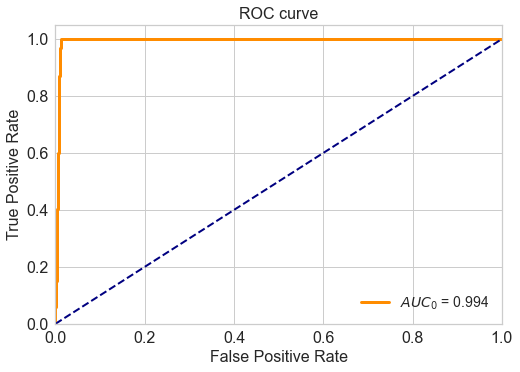

____________________________________
****** VALORE DI AUC *******
0.9942933445779747
____________________________________
****** ROC CURVE: con metodo diretto *******


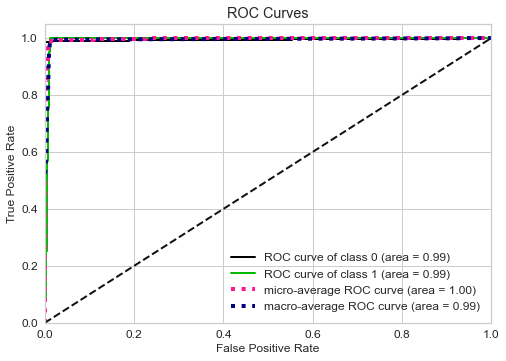

____________________________________
****** Precision recall: con metodo diretto *******


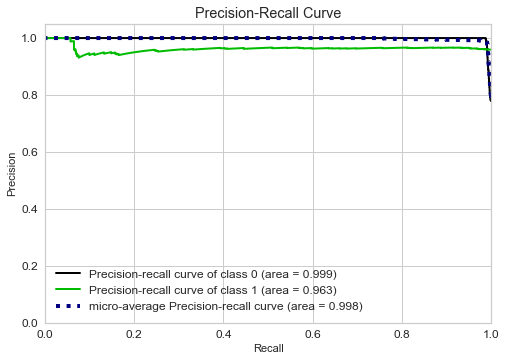

____________________________________
****** Cumulative gain: con metodo diretto *******


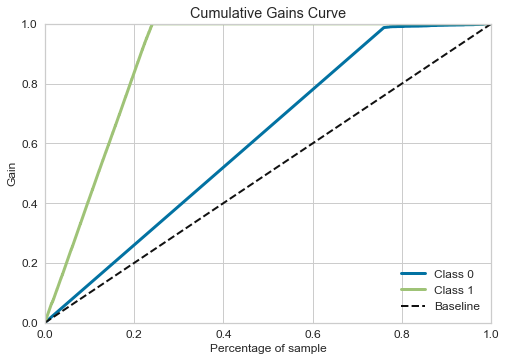

____________________________________
****** Lift curve: con metodo diretto *******


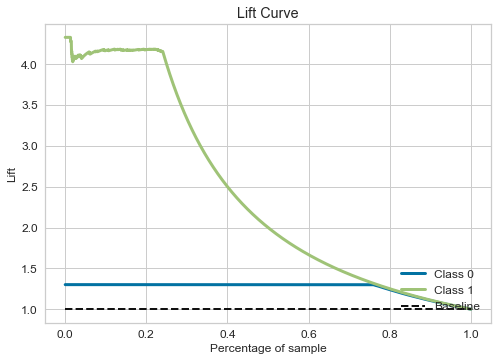

In [11]:
clf = MLPClassifier(solver = 'sgd', momentum = 0.9, learning_rate = 'adaptive' , hidden_layer_sizes=(12, 23, 11))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
result_pred(y_test, y_pred)
#y_score = clf.predict_proba(X_test)
y_score = clf.predict_proba(X_test)
plot_res(y_pred, y_score, y_test)


# Multilayer Perceptron +Oversampling

In [10]:
import warnings
from sklearn.exceptions import ConvergenceWarning
# READ AND DROP COLUMNS
y = df['Occupancy']
X = df.drop(columns=['Occupancy'])

ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=1000, stratify = y_res)
# Set the parameters by cross-validation
k_fold = StratifiedKFold(n_splits=4, random_state=42)

tuned_parameters = {
    #'tol': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7],
    #'alpha': 10.0 ** -np.arange(1, 7), 
    'momentum' : [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9],
    'hidden_layer_sizes':[(12, 23, 11,), (23, 43, 32,), (128, 64, 32,)],
    'learning_rate': ['constant', 'invscaling', 'adaptive']
}

#scores = ['recall', 'f1', 'accuracy' , 'precision']
scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for ----> %s" % score)
    print()

    svm = MLPClassifier(solver = 'sgd')

    clf = GridSearchCV(svm, tuned_parameters, scoring=score, error_score='raise', cv=k_fold)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
        clf.fit(X_train, y_train)
    
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
    print("**** Matrice di Confusione *****")
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(' True negative: %d False negative: %d' % (tn, fn))
    print(' True positive: %d False positive: %d' % (tp, fp))
    print("____________________________________________")
    
    f1_val = []
    for i in means:
        f1_val.append("%0.3f" % i)
    
    std_val = []
    for i in stds:
        std_val.append("%0.3f" % (i*2))
    
    par1 = []
    par2 = []
    par3 = []
    for i in clf.cv_results_['params']:
        par1.append(i["hidden_layer_sizes"])
        par2.append(i["momentum"])
        par3.append(i["learning_rate"])
    data = {'f1': f1_val, "std_dev":std_val, "hidden_layer_sizes":par1, "momentum":par2, "learning_rate": par3}

    res = pd.DataFrame (data, columns = ["f1", "std_dev", "hidden_layer_sizes", "momentum", "learning_rate"])
    res.to_csv('multiple_perceptron_results.csv', index=False)

Resampled dataset shape Counter({1: 15810, 0: 15810})
# Tuning hyper-parameters for ----> f1



C:\Users\Federica\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Best parameters set found on development set:

{'hidden_layer_sizes': (128, 64, 32), 'learning_rate': 'adaptive', 'momentum': 0.9}

Grid scores on development set:

0.983 (+/-0.009) for {'hidden_layer_sizes': (12, 23, 11), 'learning_rate': 'constant', 'momentum': 0}
0.981 (+/-0.016) for {'hidden_layer_sizes': (12, 23, 11), 'learning_rate': 'constant', 'momentum': 0.1}
0.987 (+/-0.003) for {'hidden_layer_sizes': (12, 23, 11), 'learning_rate': 'constant', 'momentum': 0.2}
0.985 (+/-0.010) for {'hidden_layer_sizes': (12, 23, 11), 'learning_rate': 'constant', 'momentum': 0.3}
0.992 (+/-0.003) for {'hidden_layer_sizes': (12, 23, 11), 'learning_rate': 'constant', 'momentum': 0.4}
0.992 (+/-0.002) for {'hidden_layer_sizes': (12, 23, 11), 'learning_rate': 'constant', 'momentum': 0.5}
0.992 (+/-0.002) for {'hidden_layer_sizes': (12, 23, 11), 'learning_rate': 'constant', 'momentum': 0.7}
0.993 (+/-0.001) for {'hidden_layer_sizes': (12, 23, 11), 'learning_rate': 'constant', 'momentum': 0.9}
0.224

Resampled dataset shape Counter({1: 15810, 0: 15810})
**** Matrice di Confusione *****
 True negative: 4683 False negative: 8
 True positive: 4735 False positive: 60
____________________________________________
***** Calcolo dell'accuracy *****
Frazione di campioni correttamente correlati: 0.9928
Numero di campioni correttamente correlati:  9418
____________________________________________
**** Calcolo della precisione *****
Percentuale di classificazioni positive che sono corrette: 0.9875
____________________________________________
**** Calcolo della recall (sensitivity) *****
Percentuale di elementi positivi del testing set che sono stati classificati come positivi: 0.9983
____________________________________________
**** Calcolo della specificity *****
Percentuale di elementi negativi del testing set che sono stati classificati come negativi: 0.9873
____________________________________________
**** Calcolo della F1 score *****
F1 scores: 0.9929
_____________________________________

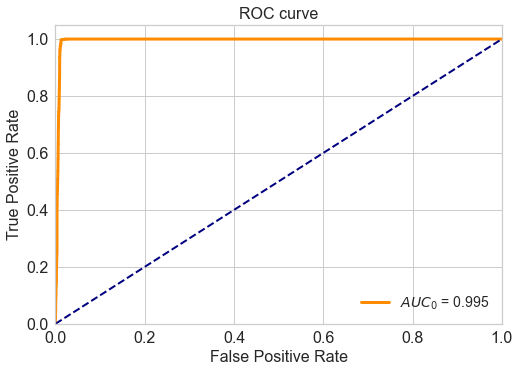

____________________________________
****** VALORE DI AUC *******
0.9948299810335585
____________________________________
****** ROC CURVE: con metodo diretto *******


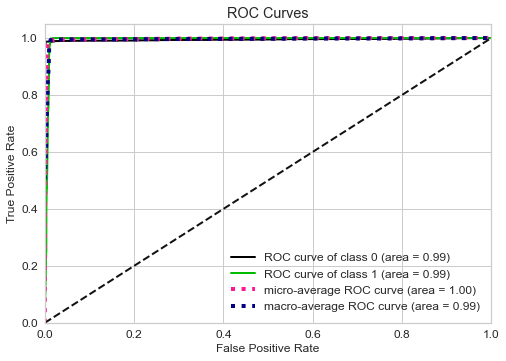

____________________________________
****** Precision recall: con metodo diretto *******


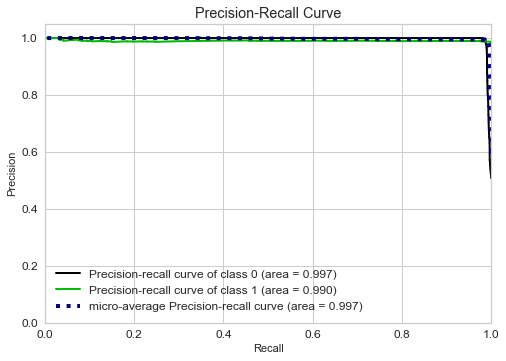

____________________________________
****** Cumulative gain: con metodo diretto *******


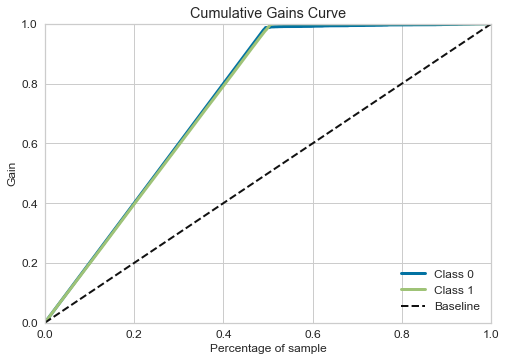

____________________________________
****** Lift curve: con metodo diretto *******


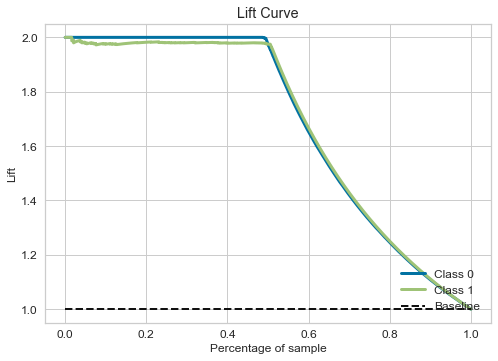

In [13]:
y = df['Occupancy']
X = df.drop(columns=['Occupancy'])

ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=1000, stratify = y_res)
clf = MLPClassifier(solver = 'sgd', momentum = 0.9, learning_rate = 'adaptive' , hidden_layer_sizes=(128, 64, 32))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
result_pred(y_test, y_pred)
#y_score = clf.predict_proba(X_test)
y_score = clf.predict_proba(X_test)
plot_res(y_pred, y_score, y_test)


# Multilayer Perceptron +Undersampling

In [11]:
import warnings
from sklearn.exceptions import ConvergenceWarning
# READ AND DROP COLUMNS
y = df['Occupancy']
X = df.drop(columns=['Occupancy'])

ros = RandomUnderSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=1000, stratify = y_res)
# Set the parameters by cross-validation
k_fold = StratifiedKFold(n_splits=4, random_state=42)

tuned_parameters = {
    #'tol': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7],
    #'alpha': 10.0 ** -np.arange(1, 7), 
    'momentum' : [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9],
    'hidden_layer_sizes':[(12, 23, 11,), (23, 43, 32,), (128, 64, 32,)],
    'learning_rate': ['constant', 'invscaling', 'adaptive']
}

#scores = ['recall', 'f1', 'accuracy' , 'precision']
scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for ----> %s" % score)
    print()

    svm = MLPClassifier(solver = 'sgd')

    clf = GridSearchCV(svm, tuned_parameters, scoring=score, error_score='raise', cv=k_fold)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
        clf.fit(X_train, y_train)
    
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
    print("**** Matrice di Confusione *****")
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(' True negative: %d False negative: %d' % (tn, fn))
    print(' True positive: %d False positive: %d' % (tp, fp))
    print("____________________________________________")
    
    f1_val = []
    for i in means:
        f1_val.append("%0.3f" % i)
    
    std_val = []
    for i in stds:
        std_val.append("%0.3f" % (i*2))
    
    par1 = []
    par2 = []
    par3 = []
    for i in clf.cv_results_['params']:
        par1.append(i["hidden_layer_sizes"])
        par2.append(i["momentum"])
        par3.append(i["learning_rate"])
    data = {'f1': f1_val, "std_dev":std_val, "hidden_layer_sizes":par1, "momentum":par2, "learning_rate": par3}

    res = pd.DataFrame (data, columns = ["f1", "std_dev", "hidden_layer_sizes", "momentum", "learning_rate"])
    res.to_csv('multiple_perceptron_results.csv', index=False)

Resampled dataset shape Counter({0: 4750, 1: 4750})
# Tuning hyper-parameters for ----> f1



C:\Users\Federica\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Best parameters set found on development set:

{'hidden_layer_sizes': (128, 64, 32), 'learning_rate': 'constant', 'momentum': 0.9}

Grid scores on development set:

0.897 (+/-0.079) for {'hidden_layer_sizes': (12, 23, 11), 'learning_rate': 'constant', 'momentum': 0}
0.938 (+/-0.040) for {'hidden_layer_sizes': (12, 23, 11), 'learning_rate': 'constant', 'momentum': 0.1}
0.954 (+/-0.028) for {'hidden_layer_sizes': (12, 23, 11), 'learning_rate': 'constant', 'momentum': 0.2}
0.945 (+/-0.035) for {'hidden_layer_sizes': (12, 23, 11), 'learning_rate': 'constant', 'momentum': 0.3}
0.963 (+/-0.005) for {'hidden_layer_sizes': (12, 23, 11), 'learning_rate': 'constant', 'momentum': 0.4}
0.973 (+/-0.006) for {'hidden_layer_sizes': (12, 23, 11), 'learning_rate': 'constant', 'momentum': 0.5}
0.978 (+/-0.017) for {'hidden_layer_sizes': (12, 23, 11), 'learning_rate': 'constant', 'momentum': 0.7}
0.991 (+/-0.002) for {'hidden_layer_sizes': (12, 23, 11), 'learning_rate': 'constant', 'momentum': 0.9}
0.333

Resampled dataset shape Counter({0: 4750, 1: 4750})
**** Matrice di Confusione *****
 True negative: 1418 False negative: 1
 True positive: 1424 False positive: 7
____________________________________________
***** Calcolo dell'accuracy *****
Frazione di campioni correttamente correlati: 0.9972
Numero di campioni correttamente correlati:  2842
____________________________________________
**** Calcolo della precisione *****
Percentuale di classificazioni positive che sono corrette: 0.9951
____________________________________________
**** Calcolo della recall (sensitivity) *****
Percentuale di elementi positivi del testing set che sono stati classificati come positivi: 0.9993
____________________________________________
**** Calcolo della specificity *****
Percentuale di elementi negativi del testing set che sono stati classificati come negativi: 0.9951
____________________________________________
**** Calcolo della F1 score *****
F1 scores: 0.9972
________________________________________

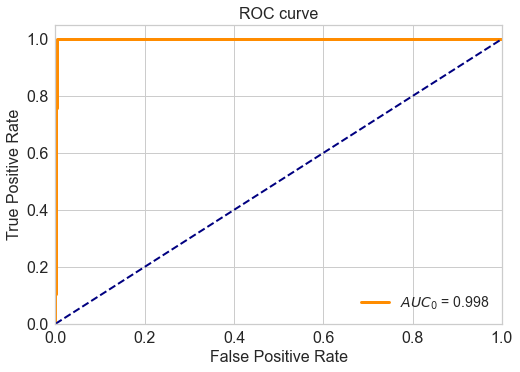

____________________________________
****** VALORE DI AUC *******
0.9983167743921205
____________________________________
****** ROC CURVE: con metodo diretto *******


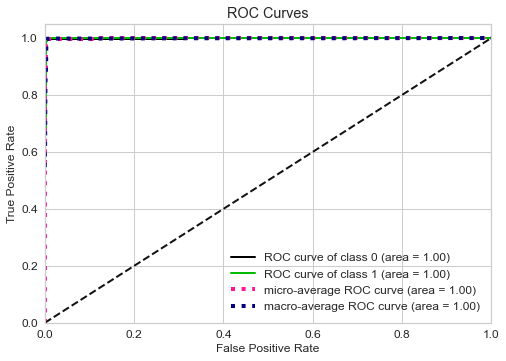

____________________________________
****** Precision recall: con metodo diretto *******


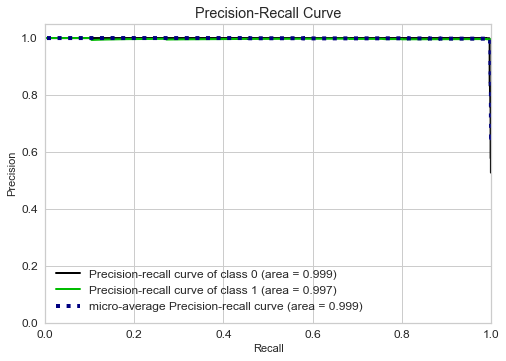

____________________________________
****** Cumulative gain: con metodo diretto *******


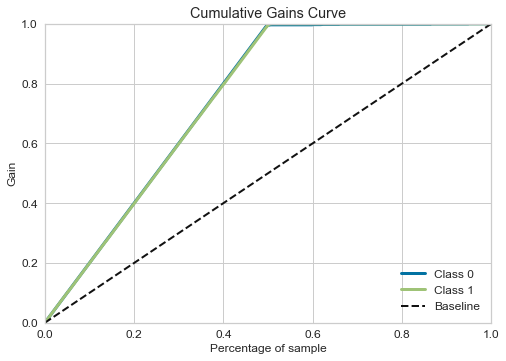

____________________________________
****** Lift curve: con metodo diretto *******


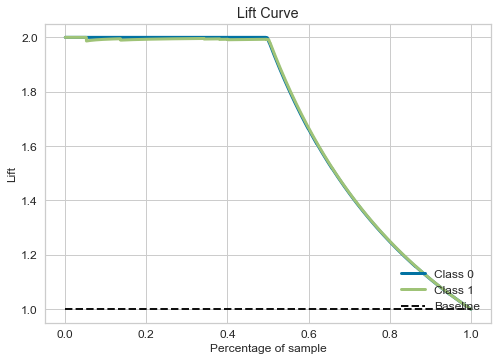

In [14]:
y = df['Occupancy']
X = df.drop(columns=['Occupancy'])

ros = RandomUnderSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=1000, stratify = y_res)
clf = MLPClassifier(solver = 'sgd', momentum = 0.9, learning_rate = 'constant' , hidden_layer_sizes=(128, 64, 32))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
result_pred(y_test, y_pred)
#y_score = clf.predict_proba(X_test)
y_score = clf.predict_proba(X_test)
plot_res(y_pred, y_score, y_test)